# Import packages and simulation class

In [1]:
## Allows for figure rendering in notebook
%matplotlib inline
'''
Simulation class for Chapter 7 Tutorial of Intro Network Science book

Copyright 2018 Indiana University and Cambridge University Press
'''

from collections import Counter
from operator import itemgetter
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
import math
import seaborn as sns
import pandas as pd
import math
from itertools import combinations

class StopCondition(StopIteration):
    pass

class Simulation:
    '''Simulate state transitions on a network'''

    def __init__(self, G, initial_state, state_transition,
            stop_condition=None, name=''):
        '''
        Create a Simulation instance.

        Args:
            G: a networkx.Graph instance.
            initial_state: function with signature `initial_state(G)`, that
                accepts a single argument, the Graph, and returns a dictionary
                of all node states. The keys in this dict should be node names
                and the values the corresponding initial node state.
            state_transition: function with signature
                `state_transition(G, current_state)` that accepts two
                arguments, the Graph and a dictionary of current node states,
                and returns a dictionary of updated node states. The keys in
                this dict should be node names and the values the corresponding
                updated node state.
            stop_condition (optional): function with signature
                `stop_condition(G, current_state)` that accepts two arguments,
                the Graph and a dictionary of current node states, and returns
                True if the simulation should be stopped at its current state.

        Keyword Args:
            name (optional): a string used in titles of plots and drawings.

        Raises:
            ValueError: if not all graph nodes have an initial state.
        '''
        self.G = G.copy()
        self._initial_state = initial_state
        self._state_transition = state_transition
        self._stop_condition = stop_condition
        # It's okay to specify stop_condition=False
        if stop_condition and not callable(stop_condition):
            raise TypeError("'stop_condition' should be a function")
        self.name = name or 'Simulation'

        self._states = []
        self._value_index = {}
        self._cmap = plt.cm.get_cmap('tab10')

        self._initialize()

        self._pos = nx.layout.spring_layout(G)

    def _append_state(self, state):
        self._states.append(state)
        # Update self._value_index
        for value in set(state.values()):
            if value not in self._value_index:
                self._value_index[value] = len(self._value_index)

    def _initialize(self):
        if self._initial_state:
            if callable(self._initial_state):
                state = self._initial_state(self.G)
            else:
                state = self._initial_state
            nx.set_node_attributes(self.G, state, 'state')

        if any(self.G.nodes[n].get('state') is None for n in self.G.nodes):
            raise ValueError('All nodes must have an initial state')

        self._append_state(state)

    def _step(self):
        # We're choosing to use the node attributes as the source of truth.
        # This allows the user to manually perturb the network in between steps.
        state = nx.get_node_attributes(self.G, 'state')
        if self._stop_condition and self._stop_condition(self.G, state):
            raise StopCondition
        #state = nx.get_node_attributes(self.G, 'state')
        new_state = self._state_transition(self.G, state)
        #state.update(new_state)
        state = new_state
        nx.set_node_attributes(self.G, state, 'state')
        self._append_state(state)

    def _categorical_color(self, value):
        index = self._value_index[value]
        node_color = self._cmap(index)
        return node_color

    @property
    def steps(self):
        ''' Returns the number of steps the sumulation has run '''
        return len(self._states) - 1

    def state(self, step=-1):
        '''
        Get a state of the simulation; by default returns the current state.

        Args:
            step: the step of the simulation to return. Default is -1, the
            current state.

        Returns:
            Dictionary of node states.

        Raises:
            IndexError: if `step` argument is greater than the number of steps.
        '''
        try:
            return self._states[step]
        except IndexError:
            raise IndexError('Simulation step %i out of range' % step)
    
    def props(self,num):
      return self.G.nodes[num]
    
    def graph(self):
      return self.G
    
    def num_nodes(self):
      return self.G.number_of_nodes()

    def draw(self, step=-1, labels=None, **kwargs):
        '''
        Use networkx.draw to draw a simulation state with nodes colored by
        their state value. By default, draws the current state.

        Args:
            step: the step of the simulation to draw. Default is -1, the
            current state.
            kwargs: keyword arguments are passed to networkx.draw()

        Raises:
            IndexError: if `step` argument is greater than the number of steps.
        '''
        state = self.state(step)
        node_colors = [self._categorical_color(state[n]) for n in self.G.nodes]
        nx.draw(self.G, pos=self._pos, node_color=node_colors, **kwargs)

        if labels is None:
            labels = sorted(set(state.values()), key=self._value_index.get)
        patches = [mpl.patches.Patch(color=self._categorical_color(l), label=l)
                   for l in labels]
        plt.legend(handles=patches)

        if step == -1:
            step = self.steps
        if step == 0:
            title = 'initial state'
        else:
            title = 'step %i' % (step)
        if self.name:
            title = '{}: {}'.format(self.name, title)
        plt.title(title)

    def plot(self, min_step=None, max_step=None, labels=None, **kwargs):
        '''
        Use pyplot to plot the relative number of nodes with each state at each
        simulation step. By default, plots all simulation steps.

        Args:
            min_step: the first step of the simulation to draw. Default is
                None, which plots starting from the initial state.
            max_step: the last step, not inclusive, of the simulation to draw.
                Default is None, which plots up to the current step.
            labels: ordered sequence of state values to plot. Default is all
                observed state values, approximately ordered by appearance.
            kwargs: keyword arguments are passed along to plt.plot()

        Returns:
            Axes object for the current plot
        '''
        x_range = range(min_step or 0, max_step or len(self._states))
        counts = [Counter(s.values()) for s in self._states[min_step:max_step]]
        if labels is None:
            labels = {k for count in counts for k in count}
            labels = sorted(labels, key=self._value_index.get)

        for label in labels:
            series = [count.get(label, 0) / sum(count.values()) for count in counts]
            plt.plot(x_range, series, label=label, **kwargs)

        title = 'node state proportions'
        if self.name:
            title = '{}: {}'.format(self.name, title)
        plt.title(title)
        plt.xlabel('Simulation step')
        plt.ylabel('Proportion of nodes')
        plt.legend()
        plt.xlim(x_range.start)

        return plt.gca()

    def run(self, steps=1):
        '''
        Run the simulation one or more steps, as specified by the `steps`
        argument. Default is to run a single step.

        Args:
            steps: number of steps to advance the simulation.
        '''
        for _ in range(steps):
            try:
                self._step()
            except StopCondition as e:
                print(
                    "Stop condition met at step %i." % self.steps
                    )
                break


# Monoculture: Hydrogen peroxide bulk addition

## Define Network, Initial State, and Transition State

## Generate initial network

In [2]:
#n=total nodes-1, m= total edges-1, mw=max weight/electrode weight, k = number of nodes connected to electrode
def mono_enet(n,m,s):

# Add nodes to networkX graph object
  G = nx.gnm_random_graph(n,m)

  # Assign node weights to zero
  for x in G.nodes():
    nx.set_node_attributes(G, {x:{'s':s,'GFP':random.gauss(500,250), 'h2o2':0}})
  

  return G

## Initial state

In [3]:
#Initialize network to have L1 population and one electrode node
def initial_estate(G):

    # Initialize the state property
    state = {}
    for g in G.nodes():
        state[g] = 'L1'

    tot = G.number_of_nodes() - 1
    state[0] = 'Electrode'
    G.nodes[0]['s'] = 0 #set substrate to zero so electrode never grows
    node_list = list(G.nodes)
    econtact = random.sample(node_list[1:], round(tot*0.05)) #5% of population is connected to the elctrode node
    for node in econtact:
        G.add_edge(0,node)

    return state

## Transition state

In [4]:
#Define a transition state for network to cycle through at each simulation step
def trans_mono_e(G, current_state):
    
    
    #At each step choose new 25% of nodes to connect to electrode
    tot = G.number_of_nodes()
    node_list = list(G.nodes)
    if round(tot*0.05) <= 130:
        econtact = random.sample(node_list[1:], round(tot*0.05))
    else:
        econtact = random.sample(node_list[1:], 130)

    next_state = {}

    #Electrode produces h2o2 for number of steps
    if trans_mono_e.counter < t_charge:
          G.nodes[0]['h2o2'] += 46
            
    #If node is within probability to turn on it it then makes GFP based on substrate and h2o2 conc    
    gfp_active =  [x for x in G.nodes if random.uniform(0,1) < 1/(1+np.exp(-.5*(G.nodes[x]['h2o2']-8))) and G.nodes[x]['h2o2'] > 0] 
    for x in gfp_active:    
        G.nodes[x]['GFP'] += 2*G.nodes[x]['s']/(1+np.exp(-(G.nodes[x]['h2o2'])))

    J = G.copy()
    for node in list(G.nodes):
      #Diffusion of h2o2 from electrode
        ci = G.nodes[node]['h2o2'] #set current concentration of this node
        G.nodes[node]['h2o2'] = ci + alpha * (\
                                        sum(J.nodes[j]['h2o2'] for j in J.neighbors(node))\
                                        -ci * J.degree(node)) *Dt
        
    #Randomize edges between L1 population 
    m = G.number_of_edges() - len(G.edges(0))
    G.remove_edges_from(G.edges())
    edges = [comb for comb in combinations(node_list[1:],2)]
    new_edges = random.sample(edges, m)
    G.add_edges_from(new_edges)
    for e in econtact:
        G.add_edge(0,e)
        
    #If nodes have more than 1 substrate weight they will grow w prob gr, 
    #by adding new node w edges to itself and up to 10 past neighbors
    #Weights are divided by two when this happens

    if trans_mono_e.counter  > t_charge:
        prob = gr 
        growing = [x for x in G.nodes if G.nodes[x]['s'] >= 1 and random.uniform(0,1) < prob]
        for g in growing:
            k = len(G.nodes)
            neighbors = list(G.neighbors(g))
            if len(neighbors) <= 10:
                    G.add_edge(g,k)
                    G.add_node(k,s = G.nodes[g]['s']/2, GFP = G.nodes[g]['GFP'], h2o2 = G.nodes[g]['h2o2']/2)
                    G.nodes[g]['s'] , G.nodes[g]['h2o2'] = G.nodes[g]['s']/2, G.nodes[g]['h2o2']/2
                    for x in neighbors:
                        G.add_edge(k,x)
                    current_state[k] = current_state[g]

            else:
                    d_neighbors = random.sample(neighbors,10)
                    G.add_edge(g,k)    
                    G.add_node(k,s = G.nodes[g]['s']/2, GFP = G.nodes[g]['GFP'], h2o2 = G.nodes[g]['h2o2']/2)
                    G.nodes[g]['s'] , G.nodes[g]['h2o2'] = G.nodes[g]['s']/2, G.nodes[g]['h2o2']/2
                    for x in d_neighbors:
                        G.add_edge(k,x)
                    current_state[k] = current_state[g]


    trans_mono_e.counter += 1

    for node in list(G.nodes):
        next_state[node] = current_state[node]

    return next_state

# Set parameters and run simulation

In [7]:
import time
start = time.time()
#Storage
steps = 400
all_counts = []
charge_times = [0, 1, 2, 4, 8, 12, 16, 30] #charge times to test
gr = 0.015 #growth rate
alpha = 1 #Diffusion constant
Dt = 0.01 #delta t

#e_deg = {}
#Test range of charge times, during charge time there's no growth so t_charge=lag_time
for k in range(10):
    data = []
    
    for t in charge_times:
        t_charge = t #how many steps electrode delivers h2o2
        trans_mono_e.counter = 0
    #Set simulation parameters
        G = mono_enet(100, 200, 20)
        sim = Simulation(G, initial_estate, trans_mono_e)
        #edges = []
    
    #Run simulation and store counts and node attributes
        for x in range(0, steps, 1):
            sim.run()
            current_state = sim.state()
            for key in current_state:
                data.append([t, key, current_state[key], x, sim.props(key)['h2o2'], sim.props(key)['GFP']])
            #edges.append(sim.graph().edges(0))
       # e_deg[t] = edges
        
  #Change lists to DF
    mono_e_df = pd.DataFrame(data)
    mono_e_df.columns = ['Charge duration [Steps]', 'Node', 'Strain','Step', 'H2O2', 'GFP'] 
    mono_e_df.to_csv('20230115_mono_e_' + str(k+1) + '.csv', index=False)
    elapsed = time.time() - start
    print(elapsed/60)

13.363866464296978
24.19477994441986
35.14153755108516
50.677814471721646
68.17624833186467
85.1728488167127
102.26926041444143
118.43629584709804
134.41898820002874
146.94367597500482


In [7]:
import time
#Set simulation weight increments and thresholds
steps = 400 #total steps of simulation
gr = 0.015 #growth rate
alpha = 1 #Diffusion constant
Dt = 0.01 #delta t
charge_times = [0, 1, 2, 4, 8, 12, 16, 30] #test range of initial h2o2 concentrations
hours = [0, 120, 240, 360]
graphs = {}
start = time.time()

#Run multiple times and save
for k in range(1): 
    data = []
    for t in charge_times:
        t_charge = t
        trans_mono_e.counter = 0
        G = mono_enet(100, 200, 20)
        sim = Simulation(G, initial_estate, trans_mono_e)
        sim.run(180)
        graphs[t] = sim.graph()


    elapsed = time.time() - start
    print(elapsed/60)

0.7331187049547832


In [9]:
import community as community_louvain
import community
partition = {}
modularity = {}
for t in charge_times:
    partition[t] = community_louvain.best_partition(graphs[t])
    modularity[t] = community.modularity(partition[t], graphs[t])

In [10]:
modularity

{0: 0.206312780907619,
 1: 0.20905182440603473,
 2: 0.20389598107056892,
 4: 0.20735551369144692,
 8: 0.21213947705046635,
 12: 0.20188071563361884,
 16: 0.21428106570189345,
 30: 0.20302087608152936}

<ipython-input-8-2f624c452463>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = data[data['Step']== 360][data['Strain'] == 'L1'][data['GFP']>=0]
<ipython-input-8-2f624c452463>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = data[data['Step']== 360][data['Strain'] == 'L1'][data['GFP']>=0]


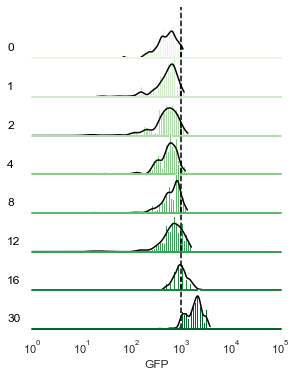

In [8]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data

data = mono_e_df
df = data[data['Step']== 360][data['Strain'] == 'L1'][data['GFP']>=0]

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="Charge duration [Steps]", hue="Charge duration [Steps]", aspect=6, height=.7, palette='Greens')

# Draw the densities in a few steps
g.map(sns.histplot, "GFP", kde=True, edgecolor = 'white', color='black', log_scale=True)
g.map(sns.histplot, "GFP", alpha = 1, log_scale=True)
g.map(plt.axvline, x=1000, ls='--', c = 'black')

# passing color=None to refline() uses the hue mapping
#g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
g.map(plt.axhline, y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.1, 0.2, label,  color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "GFP", color='black')

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
plt.xlim([1,100000])
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
#plt.title('20220919 mono_bulk', loc = 'right')
#plt.savefig('20221110 mono_bulk_biofilm', transparent=True, bbox_inches='tight')